<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-DPM2310/blob/main/ProyectoParcial/Proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Parcial**
**Inferencia de Parámteros utilizando el método de Inferencia Bayesiana y las Cadenas de Markov**

Machine Learning

Profesora: Dra. Alma Xochitl Gonzalez Morales.

Alumno: Diego Paniagua Molina.



---



+ Elige un problema, y por ende un conjunto de datos,  en el que puedas utilizar el método de inferencia de parámteros utilizando el método de inferencia bayesiana y las cadenas de markov.

1. El número de parámetros a estimar debe ser mayor a 2
2. El modelo debe ser diferente a una linea recta
3. El likelihood se recomienda sea Gaussiano
4. Utiliza priors planos



---



# **Prediccion de la Cagra de un Capacitor**

La ecuación que modela la carga de un capacitor en un circuito RC es:

$$V(t) = V_{\text{max}} \left(1 - e^{-\frac{t}{RC}}\right)\$$

Donde:
- $V(t)$ es el voltaje en el capacitor en un momento dado \(t\).
- $V_{\text{max}}$ es el voltaje máximo que el capacitor puede alcanzar.
- $R$ es la resistencia en el circuito.
- $C$ es la capacitancia del capacitor.
- $e$ es la base del logaritmo natural.

Esta ecuación describe cómo el voltaje en un capacitor cambia a medida que pasa el tiempo durante el proceso de carga en un circuito RC.

Los datos medidos experimentalmente fueron tomados den el laboratorio de la DCI.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import emcee
import corner

In [6]:
!pip install emcee
!pip install corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.4 MB/s eta 0:00:00


In [33]:
# Cargamos los datos desde Drive
drive.mount('/content/drive')
file ="/content/drive/MyDrive/Machine Learning/Data/datos_carga_capacitor.txt"

data = np.loadtxt(file,delimiter=",").T
t, V = data[0], data[1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


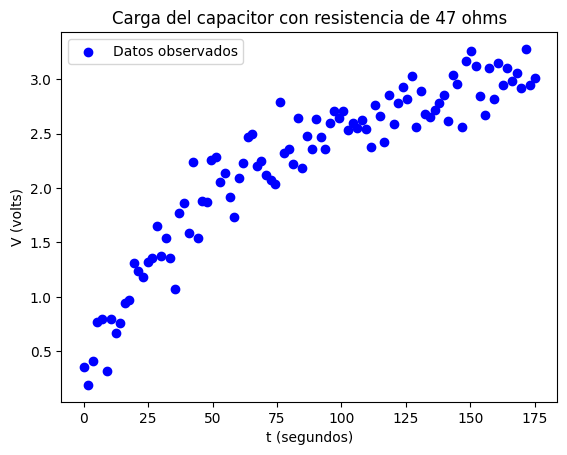

In [34]:
# Visualizamos los datos obtenidos
plt.figure()
plt.title('Carga del capacitor con resistencia de 47 ohms')
plt.scatter(t, V, label='Datos observados', color='blue')
plt.xlabel('t (segundos)')
plt.ylabel('V (volts)')
plt.legend()

plt.show()

In [9]:
# Comenzamos con la implementacion del metodo de MCMC

# Definimos el modelo
def modelo_carga_capacitor(params, C):
  V_max, R, C = params
  return V_max*(1-np.exp(-t/(R*C)))

# Definimos nuestro Log-likelihood
def log_likelihood(params, t, y, sigma):
    modelo = modelo_carga_capacitor(params, t)
    residuo = y - modelo
    return -0.5 * np.sum((residuo / sigma)**2)

# Priors planos
def log_prior(params):
    V_max, R, C = params
    if 0 < V_max < 10 and 0 < R < 5000 and 0 < C < 0.01:
        return 0.0
    return -np.inf

# Log-posterior
def log_posterior(params, t, y, sigma):
    prior = log_prior(params)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(params, t, y, sigma)

In [24]:
# Configuracion MCMC

V_real = 3.0      # Voltaje máximo del capacitor
R_real = 47.0     # Resistencia en ohmios
C_real = 1.0      # Capacitancia en faradios
n_walkers = 100
n_dim = 3
param_names = ["V_max", "R", "C"]

# Inicializamos de forma aleatoria los caminantes
initial_params = np.random.rand(n_walkers, n_dim) * [10, 5000, 0.01]

# Defininimos nuestri sigma (desviación estándar)
sigma = 0.1 * np.ones_like(V)

# Configuraramos el sampler emcee
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(t, V, sigma))

# Realizamos el muestreo
n_steps = 5000
pos, prob, state = sampler.run_mcmc(initial_params, n_steps, progress=True)

100%|██████████| 5000/5000 [00:12<00:00, 392.08it/s]


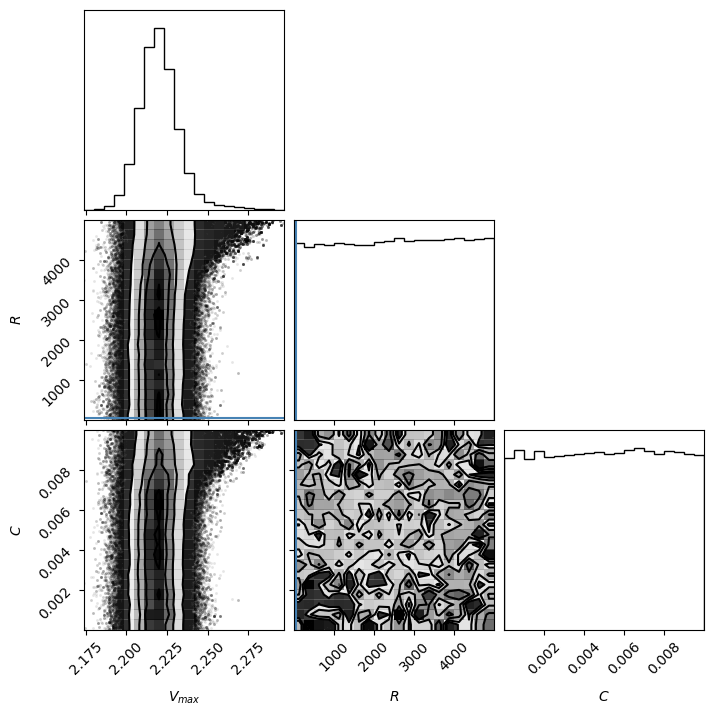

In [23]:
# Visualizamos los resultados con corner plot
samples = sampler.chain[:, 100:, :].reshape((-1, n_dim))
fig = corner.corner(samples, labels=["$V_{max}$", "$R$", "$C$"], truths=[V_real, R_real, C_real])
fig.show()

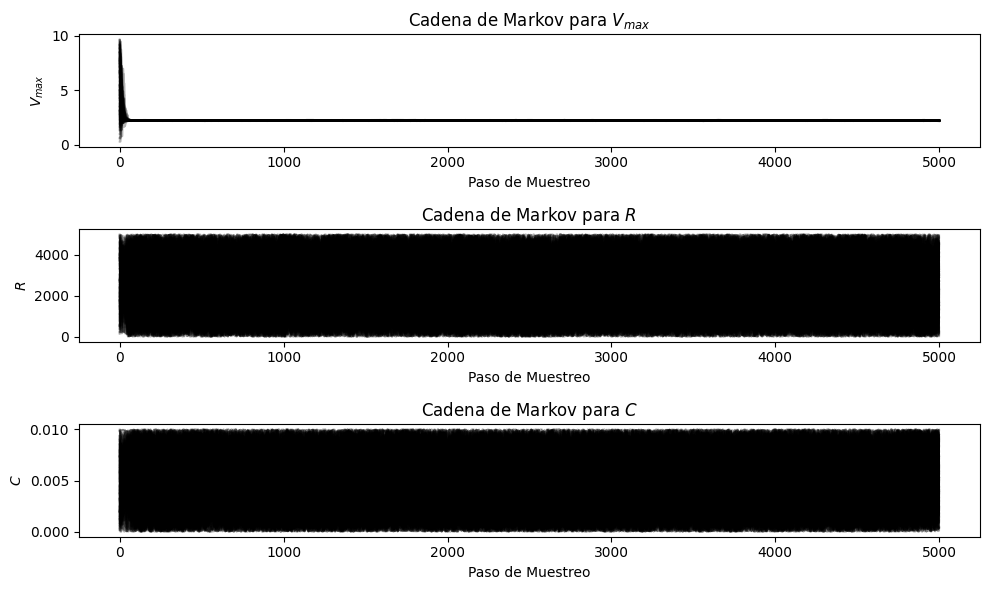

In [17]:
# Graficamos las cadenas de Markov asociadas a cada parametro

# Obtenemos las trazas de las cadenas de Markov
trazas_V_max = sampler.chain[:, :, 0].T
trazas_R = sampler.chain[:, :, 1].T
trazas_C = sampler.chain[:, :, 2].T

# Creamos subgráficos para cada parámetro
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(trazas_V_max, color='k', alpha=0.3)
plt.xlabel('Paso de Muestreo')
plt.ylabel('$V_{max}$')
plt.title('Cadena de Markov para $V_{max}$')

plt.subplot(3, 1, 2)
plt.plot(trazas_R, color='k', alpha=0.3)
plt.xlabel('Paso de Muestreo')
plt.ylabel('$R$')
plt.title('Cadena de Markov para $R$')

plt.subplot(3, 1, 3)
plt.plot(trazas_C, color='k', alpha=0.3)
plt.xlabel('Paso de Muestreo')
plt.ylabel('$C$')
plt.title('Cadena de Markov para $C$')

plt.tight_layout()
plt.show()

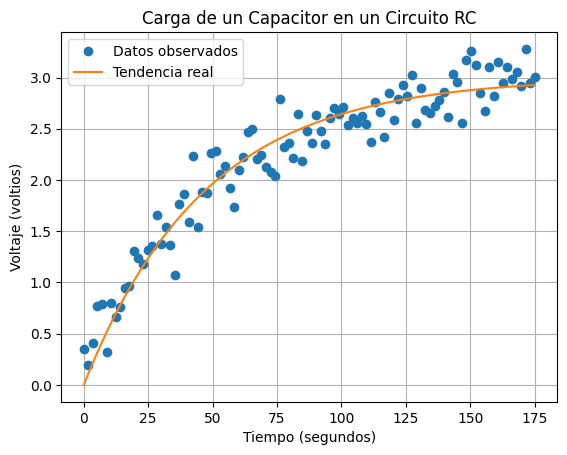

In [31]:
# Generamos un rango de tiempo de 0 a 175 segundos
tiempo = np.linspace(0, 175, 100)

# Calculamos el voltaje en el capacitor en función del tiempo
voltaje_teorico = V_real * (1 - np.exp(-tiempo / (R_real * C_real)))

# Creamos el gráfico de voltaje vs tiempo
plt.plot(tiempo, V, 'o', label='Datos observados')
plt.plot(tiempo, voltaje_teorico, label='Tendencia real')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Voltaje (voltios)')
plt.title('Carga de un Capacitor en un Circuito RC')
plt.legend()
plt.grid(True)

plt.show()